# 1. PRE-PROCESSING DATASET UNTUK NER (DATASET CONSTRUCTION).

In [22]:
import json
import pandas as pd

# =============================
# 1. LOAD & MERGE ANNOTATIONS
# =============================
file_path = "dataset2.json"

with open(file_path, "r", encoding="utf-8") as f:
    raw = json.load(f)

print("Total items loaded:", len(raw))


def extract_annotations(item):
    """Ambil anotasi dari annotations atau drafts."""
    results = []

    # Jika annotations ada
    if "annotations" in item and len(item["annotations"]) > 0:
        for r in item["annotations"][0].get("result", []):
            results.append(r)

    # Jika drafts berisi hasil labeling
    if "drafts" in item and len(item["drafts"]) > 0:
        for r in item["drafts"][0].get("result", []):
            results.append(r)

    return results


# =============================
# 2. CLEAN ANNOTATIONS
# =============================
def clean_entities(results):
    clean = []

    for r in results:
        if "value" not in r:
            continue
        v = r["value"]

        if "start" not in v or "end" not in v or "labels" not in v:
            continue

        start = v["start"]
        end = v["end"]

        # Skip range invalid
        if start >= end:
            continue

        label = v["labels"][0]

        # Skip label tidak dipakai
        if label == "NAMA_FILE":
            continue

        clean.append({
            "start": start,
            "end": end,
            "label": label
        })

    # Urutkan anotasi berdasarkan start
    clean.sort(key=lambda x: x["start"])
    return clean


# =============================
# 3. BUILD BIO FROM CHARACTER MASK
# =============================
def build_bio(text, entities):
    bio = ["O"] * len(text)

    for ent in entities:
        s, e, label = ent["start"], ent["end"], ent["label"]

        bio[s] = f"B-{label}"
        for i in range(s + 1, e):
            if i < len(bio):
                bio[i] = f"I-{label}"

    return bio


# =============================
# 4. CONVERT TO TOKEN + BIO BY WORD
# =============================
def tokenize_and_align(text, bio):
    tokens = []
    tags = []

    cursor = 0
    words = text.split()

    for word in words:
        idx = text.find(word, cursor)
        if idx == -1:
            cursor += len(word) + 1
            continue

        tokens.append(word)
        tags.append(bio[idx])  # label karakter pertama kata

        cursor = idx + len(word)

    return tokens, tags


# =============================
# 5. PROCESS ALL DOCUMENTS
# =============================
final = []

for item in raw:
    if "data" not in item or "text" not in item["data"]:
        continue

    text = item["data"]["text"]

    raw_results = extract_annotations(item)
    entities = clean_entities(raw_results)

    bio = build_bio(text, entities)

    tokens, tags = tokenize_and_align(text, bio)

    final.append({
        "tokens": tokens,
        "ner_tags": tags
    })

df = pd.DataFrame(final)

df.to_csv("ner_dataset_ready.csv", index=False)
print("Saved dataset to ner_dataset_ready.csv")
print("Total processed:", len(df))
print(df.head())


Total items loaded: 250
Saved dataset to ner_dataset_ready.csv
Total processed: 250
                                              tokens  \
0  [PUTUSAN, Putusan, Nomor, 172, PK/Pid/2023, DE...   
1  [PUTUSAN, Putusan, Nomor, 181, PK/Pid/2023, DE...   
2  [PUTUSAN, Putusan, Nomor, 186, K/Pid/2023, DEM...   
3  [PUTUSAN, Putusan, Nomor, 243, K/Pid/2023, DEM...   
4  [PUTUSAN, Putusan, Nomor, 338, K/Pid/2023, DEM...   

                                            ner_tags  
0  [O, O, O, B-NOMOR_PUTUSAN, I-NOMOR_PUTUSAN, O,...  
1  [O, O, O, B-NOMOR_PUTUSAN, I-NOMOR_PUTUSAN, O,...  
2  [O, O, O, B-NOMOR_PUTUSAN, I-NOMOR_PUTUSAN, O,...  
3  [O, O, O, B-NOMOR_PUTUSAN, I-NOMOR_PUTUSAN, O,...  
4  [O, O, O, B-NOMOR_PUTUSAN, I-NOMOR_PUTUSAN, O,...  


# 2. DATASET ANOTASI

## 2.1 DATASET NER (INDO-LEGAL-BERT)


In [5]:
# ============================================================
# NER TRAINING (CLEAN, NO LEAKAGE, STRICT BIO)
# ============================================================

import json, os, random
from collections import Counter
import numpy as np
import pandas as pd
import torch

from datasets import Dataset, DatasetDict
import evaluate

from transformers import (
    AutoTokenizer,
    BertForTokenClassification,
    BertConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
    EarlyStoppingCallback
)

# ---------------- USER CONFIG ----------------
DATA_JSON = "dataset2.json"
MODEL_CHECKPOINT = "archi-ai/Indo-LegalBERT"
OUTPUT_DIR = "model_final_ner_clean"
MAX_LENGTH = 256
SEED = 42
FP16 = True
# ---------------------------------------------

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ============================================================
# 1. LOAD & CLEAN DATA
# ============================================================

with open(DATA_JSON, "r", encoding="utf-8") as f:
    raw = json.load(f)

def extract_results(item):
    out = []
    if item.get("annotations"):
        out.extend(item["annotations"][0].get("result", []))
    if item.get("drafts"):
        out.extend(item["drafts"][0].get("result", []))
    return out

def clean_results(results):
    ents = []
    for r in results:
        v = r.get("value", {})
        if not all(k in v for k in ("start", "end", "labels")):
            continue
        if v["start"] >= v["end"]:
            continue
        label = v["labels"][0]
        if label == "NAMA_FILE":
            continue
        ents.append({
            "start": v["start"],
            "end": v["end"],
            "label": label
        })
    return sorted(ents, key=lambda x: x["start"])

processed = []
for idx, item in enumerate(raw):
    text = item.get("data", {}).get("text")
    if not text:
        continue

    entities = clean_results(extract_results(item))

    # char-level BIO
    char_tags = ["O"] * len(text)
    for ent in entities:
        char_tags[ent["start"]] = f"B-{ent['label']}"
        for i in range(ent["start"] + 1, min(ent["end"], len(text))):
            char_tags[i] = f"I-{ent['label']}"

    tokens, tags = [], []
    cursor = 0
    for word in text.split():
        pos = text.find(word, cursor)
        if pos == -1:
            continue
        tokens.append(word)
        tags.append(char_tags[pos])
        cursor = pos + len(word)

    if tokens:
        processed.append({
            "doc_id": idx,
            "tokens": tokens,
            "ner_tags": tags
        })

df = pd.DataFrame(processed)
print("Total documents:", len(df))

# ============================================================
# 2. LABEL SET (INCLUDE 'O')
# ============================================================

labels = set(["O"])
for tags in df["ner_tags"]:
    labels.update(tags)

label_list = sorted(labels)
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}

print("Num labels:", len(label_list))

# ============================================================
# 3. LEAKAGE-SAFE SPLIT (DOCUMENT LEVEL)
# ============================================================

train_ids = df.sample(frac=0.8, random_state=SEED)["doc_id"]
train_df = df[df.doc_id.isin(train_ids)]
test_df = df[~df.doc_id.isin(train_ids)]

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test": Dataset.from_pandas(test_df)
})

# ============================================================
# 4. TOKENIZATION + STRICT BIO ALIGNMENT
# ============================================================

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_and_align_labels(examples):
    tokenized = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        max_length=MAX_LENGTH
    )

    aligned_labels = []
    for i, labels in enumerate(examples["ner_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        prev_word = None
        label_ids = []

        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            else:
                tag = labels[word_id]
                if tag == "O":
                    label_ids.append(label2id["O"])
                else:
                    if word_id != prev_word:
                        label_ids.append(label2id[tag])
                    else:
                        label_ids.append(label2id[tag.replace("B-", "I-")])
            prev_word = word_id

        aligned_labels.append(label_ids)

    tokenized["labels"] = aligned_labels
    return tokenized

tokenized_ds = dataset.map(tokenize_and_align_labels, batched=True)

# ============================================================
# 5. MODEL
# ============================================================

config = BertConfig.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

model = BertForTokenClassification.from_pretrained(
    MODEL_CHECKPOINT,
    config=config,
    ignore_mismatched_sizes=True
)

model.gradient_checkpointing_enable()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ============================================================
# 6. METRICS (OVERALL + PER LABEL)
# ============================================================

metric = evaluate.load("seqeval")

def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=2)

    true_preds, true_labels = [], []
    for p_seq, l_seq in zip(preds, labels):
        tp, tl = [], []
        for p_i, l_i in zip(p_seq, l_seq):
            if l_i != -100:
                tp.append(id2label[p_i])
                tl.append(id2label[l_i])
        true_preds.append(tp)
        true_labels.append(tl)

    res = metric.compute(predictions=true_preds, references=true_labels)

    out = {
        "precision": res["overall_precision"],
        "recall": res["overall_recall"],
        "f1": res["overall_f1"]
    }

    for k, v in res.items():
        if isinstance(v, dict) and "f1" in v:
            out[f"f1_{k}"] = v["f1"]

    return out

# ============================================================
# 7. TRAINING
# ============================================================

args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8,
    num_train_epochs=15,
    warmup_ratio=0.1,
    weight_decay=0.01,
    fp16=FP16,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ============================================================
# 8. TRAIN & SAVE
# ============================================================

trainer.train()

model.save_pretrained(OUTPUT_DIR, safe_serialization=True)
tokenizer.save_pretrained(OUTPUT_DIR)

print("✅ Training complete. Model saved to:", OUTPUT_DIR)


Total documents: 250
Num labels: 27


Map: 100%|██████████| 50/50 [00:00<00:00, 536.48 examples/s]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at archi-ai/Indo-LegalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\User\AppData\Local\Temp\ipykernel_11476\3423197837.py:250: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,F1 Agama Terdakwa,F1 Lokasi Pengadilan,F1 Nama Terdakwa,F1 Nomor Putusan,F1 Tanggal Lahir Terdakwa,F1 Vonis Penjara
1,No log,0.521166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,No log,0.058250,0.774390,0.798742,0.786378,0.848921,0.380952,0.915493,1.000000,0.914286,0.000000
3,No log,0.038424,0.778667,0.918239,0.842713,1.000000,0.909091,0.957143,1.000000,0.942857,0.064516
4,No log,0.018167,0.865497,0.930818,0.896970,1.000000,1.000000,0.957143,1.000000,0.942857,0.100000
5,No log,0.005386,0.943396,0.943396,0.943396,1.000000,1.000000,0.957143,1.000000,1.000000,0.166667
6,No log,0.004398,0.952830,0.952830,0.952830,1.000000,1.000000,1.000000,1.000000,1.000000,0.166667
7,No log,0.003660,0.952830,0.952830,0.952830,1.000000,1.000000,1.000000,1.000000,1.000000,0.166667
8,No log,0.003306,0.952830,0.952830,0.952830,1.000000,1.000000,1.000000,1.000000,1.000000,0.166667
9,No log,0.003340,0.952830,0.952830,0.952830,1.000000,1.000000,1.000000,1.000000,1.000000,0.166667


c:\Users\User\Desktop\KULIAH\SEMESTER 5\NLP\envnlp\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\Desktop\KULIAH\SEMESTER 5\NLP\envnlp\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


✅ Training complete. Model saved to: model_final_ner_clean


## 2.2 DATASET SENTENCE CLASSIFICATION

### A. Pembentukan Dataset Sentence Classification dari Anotasi NER

In [15]:
import json
import re

INPUT_JSON = "dataset2.json"
OUTPUT_JSON = "dataset_sentence.json"

with open(INPUT_JSON, encoding="utf-8") as f:
    data = json.load(f)

sentence_data = []

for item in data:
    text = item["data"]["text"]

    # pecah jadi kalimat
    sentences = re.split(r'(?<=[.!?])\s+', text)

    results = []
    if item.get("annotations"):
        results += item["annotations"][0]["result"]
    if item.get("drafts"):
        results += item["drafts"][0]["result"]

    for r in results:
        v = r["value"]
        label = v["labels"][0]
        start, end = v["start"], v["end"]

        for sent in sentences:
            if v["text"] in sent:
                sentence_data.append({
                    "text": sent.strip(),
                    "label": label
                })
                break

print("Total sentence data:", len(sentence_data))

with open(OUTPUT_JSON, "w", encoding="utf-8") as f:
    json.dump(sentence_data, f, ensure_ascii=False, indent=2)

print("✅ dataset_sentence.json selesai")


Total sentence data: 3287
✅ dataset_sentence.json selesai


#### B. Pelatihan Model Sentence Classification Berbasis IndoLegalBERT

In [7]:
# ============================================================
# SENTENCE CLASSIFICATION TRAINING - INDOLEGALBERT (FINAL)
# ============================================================

import json, random
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
import evaluate

# ================== CONFIG ==================
DATASET_PATH = "dataset_sentence.json"
MODEL_NAME = "archi-ai/Indo-LegalBERT"
OUTPUT_DIR = "model_sentence_classifier"
MAX_LENGTH = 256
SEED = 42
EPOCHS = 3
# ============================================

# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ============================================================
# 1. LOAD DATA
# ============================================================
with open(DATASET_PATH, encoding="utf-8") as f:
    data = json.load(f)

texts = [d["text"] for d in data]
labels = [d["label"] for d in data]

label_list = sorted(list(set(labels)))
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}

encoded_labels = [label2id[l] for l in labels]

dataset = Dataset.from_dict({
    "text": texts,
    "label": encoded_labels
})

dataset = dataset.train_test_split(test_size=0.2, seed=SEED)

print("Labels:", label2id)

# ============================================================
# 2. TOKENIZER (DYNAMIC PADDING)
# ============================================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=MAX_LENGTH
    )

dataset = dataset.map(tokenize, batched=True)
dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

data_collator = DataCollatorWithPadding(tokenizer)

# ============================================================
# 3. MODEL
# ============================================================
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# Hemat VRAM
model.gradient_checkpointing_enable()

# ============================================================
# 4. METRICS
# ============================================================
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "f1": metric.compute(
            predictions=preds,
            references=labels,
            average="macro"
        )["f1"]
    }

# ============================================================
# 5. TRAINING (ANTI OOM)
# ============================================================
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,  # effective batch = 16
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

# ============================================================
# 6. SAVE MODEL
# ============================================================
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print("✅ Training selesai. Model disimpan di:", OUTPUT_DIR)


Labels: {'AGAMA_TERDAKWA': 0, 'AKIBAT_TINDAK_PIDANA': 1, 'KORBAN': 2, 'LOKASI_PENGADILAN': 3, 'MODUS_TINDAK_PIDANA': 4, 'NAMA_HAKIM': 5, 'NAMA_TERDAKWA': 6, 'NOMOR_PUTUSAN': 7, 'PASAL_DAKWAAN': 8, 'STATUS_PUTUSAN': 9, 'TANGGAL_LAHIR_TERDAKWA': 10, 'TANGGAL_PUTUSAN': 11, 'VONIS_PENJARA': 12}


Map: 100%|██████████| 658/658 [00:00<00:00, 18360.58 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at archi-ai/Indo-LegalBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\User\AppData\Local\Temp\ipykernel_21268\2924843177.py:121: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.786434,0.643001
2,No log,0.801873,0.633954
3,No log,0.763311,0.656528


✅ Training selesai. Model disimpan di: model_sentence_classifier


# 3. Ekstraksi Informasi Terstruktur dari Putusan Pengadilan Menggunakan NER dan Klasifikasi Kalimat

In [11]:
import torch, glob, os
import pandas as pd
from tqdm import tqdm
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    AutoModelForSequenceClassification
)

# ================= CONFIG =================
NER_MODEL_DIR = "model_final_ner_clean"
SENT_MODEL_DIR = "model_sentence_classifier"

INPUT_TXT = r"C:\Users\User\Desktop\KULIAH\SEMESTER 5\NLP\FINAL PROJEK\Hasil_TXT\TXT_CLEAN\*.txt"
OUTPUT_FILE = "HASIL_FINAL_PIPELINE_B.xlsx"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# =========================================

# ================= LOAD MODELS =================
ner_tokenizer = AutoTokenizer.from_pretrained(NER_MODEL_DIR)
ner_model = AutoModelForTokenClassification.from_pretrained(NER_MODEL_DIR).to(DEVICE).eval()

sent_tokenizer = AutoTokenizer.from_pretrained(SENT_MODEL_DIR)
sent_model = AutoModelForSequenceClassification.from_pretrained(SENT_MODEL_DIR).to(DEVICE).eval()

# ================= NER FUNCTIONS =================
def ner_predict_chunk(text):
    inputs = ner_tokenizer(
        text, return_tensors="pt",
        truncation=True, max_length=512
    ).to(DEVICE)

    with torch.no_grad():
        logits = ner_model(**inputs).logits

    preds = torch.argmax(logits, dim=2)[0].cpu().numpy()
    tokens = ner_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    labels = [ner_model.config.id2label[p] for p in preds]
    return tokens, labels


def ner_decode(tokens, labels):
    entities, ent, lbl = [], "", None

    for t, l in zip(tokens, labels):
        if t in ["[CLS]", "[SEP]", "[PAD]"]:
            continue

        clean = t.replace("##", "")
        if l.startswith("B-"):
            if ent:
                entities.append((lbl, ent.strip()))
            lbl = l[2:]
            ent = clean
        elif l.startswith("I-") and lbl == l[2:]:
            ent += clean if t.startswith("##") else " " + clean
        else:
            if ent:
                entities.append((lbl, ent.strip()))
            ent, lbl = "", None

    if ent:
        entities.append((lbl, ent.strip()))
    return entities


def ner_process(text):
    words = text.split()
    out = []
    i = 0
    while i < len(words):
        chunk = " ".join(words[i:i+350])
        t, l = ner_predict_chunk(chunk)
        out.extend(ner_decode(t, l))
        i += 300
    return out


def ner_to_record(entities):
    fields = [
        "NOMOR_PUTUSAN","LOKASI_PENGADILAN","NAMA_HAKIM",
        "TANGGAL_PUTUSAN","NAMA_TERDAKWA","TANGGAL_LAHIR_TERDAKWA",
        "AGAMA_TERDAKWA"
    ]
    rec = {f: [] for f in fields}
    for l, t in entities:
        if l in rec:
            rec[l].append(t)

    return {k: max(v, key=len) if v else "-" for k, v in rec.items()}

# ================= SENTENCE CLASSIFIER =================
def classify_sentences(text):
    sentences = [s.strip() for s in text.split(".") if len(s.strip()) > 20]
    results = []

    for s in sentences:
        inputs = sent_tokenizer(
            s, return_tensors="pt",
            truncation=True, max_length=256
        ).to(DEVICE)

        with torch.no_grad():
            out = sent_model(**inputs)
            probs = torch.softmax(out.logits, dim=1)[0]
            pred = probs.argmax().item()

        results.append({
            "label": sent_model.config.id2label[pred],
            "score": probs[pred].item(),
            "text": s
        })
    return results


def aggregate_sentences(preds):
    out = {}
    for p in preds:
        l = p["label"]
        if l not in out or p["score"] > out[l]["score"]:
            out[l] = p
    return {k: v["text"] for k, v in out.items()}

# ================= MAIN =================
def main():
    rows = []

    for path in tqdm(glob.glob(INPUT_TXT), desc="Processing"):
        with open(path, encoding="utf-8", errors="ignore") as f:
            text = f.read()

        ner_entities = ner_process(text)
        ner_record = ner_to_record(ner_entities)

        sent_preds = classify_sentences(text)
        sent_record = aggregate_sentences(sent_preds)

        final = {**ner_record, **sent_record}
        final["NAMA_FILE"] = os.path.basename(path)
        rows.append(final)

    df = pd.DataFrame(rows)
    df = df[["NAMA_FILE"] + [c for c in df.columns if c != "NAMA_FILE"]]
    df.to_excel(OUTPUT_FILE, index=False)
    print("✅ SELESAI:", OUTPUT_FILE)


if __name__ == "__main__":
    main()


Processing: 100%|██████████| 250/250 [11:55<00:00,  2.86s/it]

✅ SELESAI: HASIL_FINAL_PIPELINE_B.xlsx


# 4. VISUALISASI SEMANTIC

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


In [16]:
INPUT_EXCEL = "HASIL_FINAL_PIPELINE_B.xlsx"   # ganti jika perlu


In [17]:
def build_semantic_graph(row):
    G = nx.DiGraph()

    terdakwa = row.get("NAMA_TERDAKWA", "-")
    if terdakwa == "-" or pd.isna(terdakwa):
        return G

    # Node utama
    G.add_node(terdakwa, type="TERDAKWA")

    relations = {
        "NOMOR_PUTUSAN": "memiliki_putusan",
        "LOKASI_PENGADILAN": "disidangkan_di",
        "NAMA_HAKIM": "diputus_oleh",
        "PASAL_DAKWAAN": "didakwa_dengan",
        "VONIS_PENJARA": "dijatuhi_vonis",
        "KORBAN": "terhadap_korban",
        "STATUS_PUTUSAN": "status_putusan"
    }

    for col, rel in relations.items():
        val = row.get(col, "-")
        if val != "-" and not pd.isna(val):
            G.add_node(val, type=col)
            G.add_edge(terdakwa, val, label=rel)

    return G


In [18]:
def visualize_graph(G, title):
    if len(G.nodes) == 0:
        print("Graf kosong")
        return

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)

    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=3000,
        node_color="lightblue",
        font_size=9,
        font_weight="bold",
        arrows=True
    )

    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title(title)
    plt.axis("off")
    plt.show()


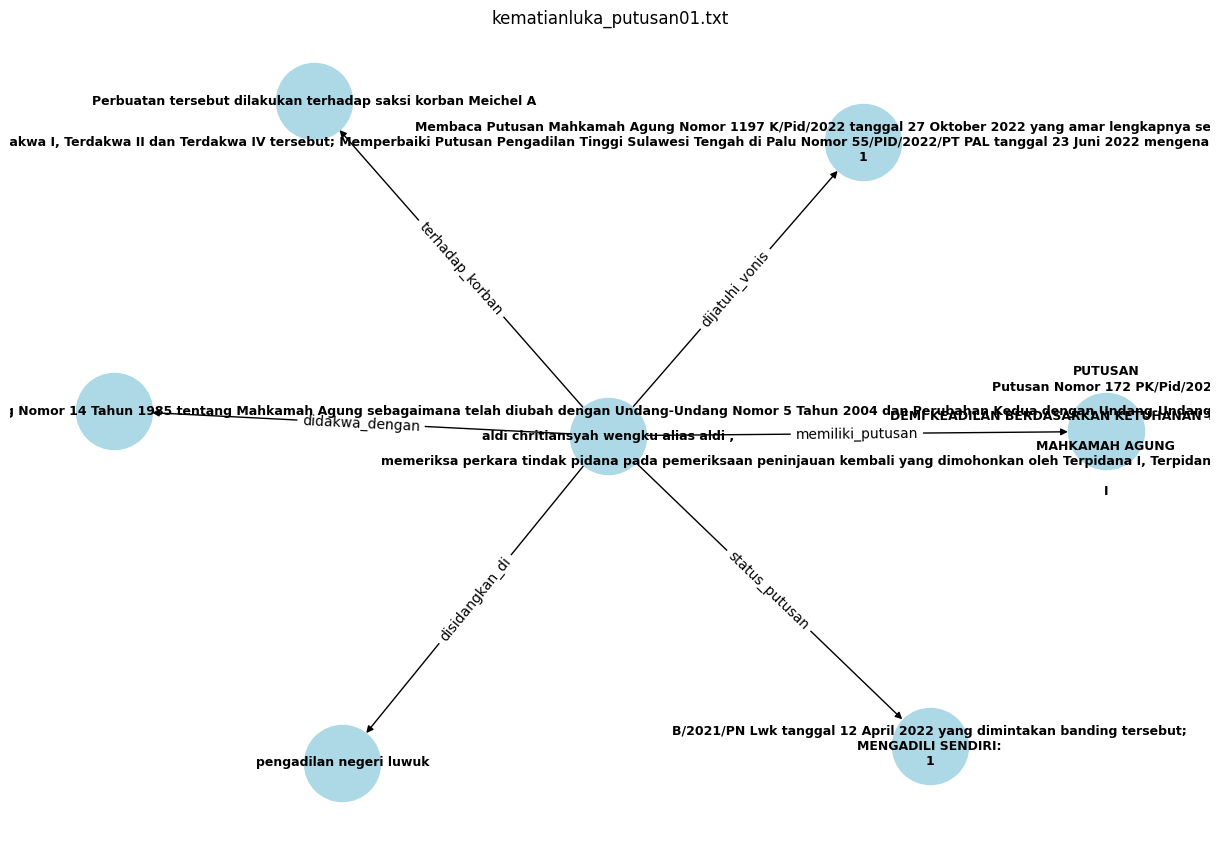

In [21]:
def main():
    df = pd.read_excel(INPUT_EXCEL)

    # visualisasi 1 dokumen (misal baris pertama)
    row = df.iloc[0]

    G = build_semantic_graph(row)
    visualize_graph(G, title=row.get("NAMA_FILE", "Graf Semantik"))


if __name__ == "__main__":
    main()


## 6. IndoBERT-base (Transformer ringan)

In [44]:
# ============================================================
# NER TRAINING - INDOBERT BASE (REALISTIC, NO LEAKAGE)
# ============================================================

import json, random
import numpy as np
import pandas as pd
import torch
from datasets import Dataset, DatasetDict
import evaluate

from transformers import (
    AutoTokenizer,
    BertForTokenClassification,
    BertConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
    EarlyStoppingCallback
)

# ================= CONFIG =================
DATA_JSON = "dataset2.json"
MODEL_CHECKPOINT = "indobenchmark/indobert-base-p1"
OUTPUT_DIR = "indobert_ner_realistic"
MAX_LENGTH = 256
SEED = 42
# ==========================================

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ============================================================
# 1. LOAD & PREPARE DATA (DOCUMENT LEVEL)
# ============================================================

with open(DATA_JSON, encoding="utf-8") as f:
    raw = json.load(f)

def extract_entities(item):
    out = []
    if item.get("annotations"):
        out += item["annotations"][0]["result"]
    if item.get("drafts"):
        out += item["drafts"][0]["result"]
    return out

processed = []

for doc_id, item in enumerate(raw):
    text = item["data"]["text"]
    entities = extract_entities(item)

    char_tags = ["O"] * len(text)
    for r in entities:
        v = r["value"]
        label = v["labels"][0]
        s, e = v["start"], v["end"]
        char_tags[s] = f"B-{label}"
        for i in range(s + 1, e):
            char_tags[i] = f"I-{label}"

    tokens, tags = [], []
    cursor = 0
    for w in text.split():
        pos = text.find(w, cursor)
        if pos == -1:
            continue
        tokens.append(w)
        tags.append(char_tags[pos])
        cursor = pos + len(w)

    if tokens:
        processed.append({
            "doc_id": doc_id,
            "tokens": tokens,
            "ner_tags": tags
        })

df = pd.DataFrame(processed)

# ============================================================
# 2. LABEL SET
# ============================================================

labels = sorted({t for row in df.ner_tags for t in row})
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}

# ============================================================
# 3. DOCUMENT-LEVEL SPLIT (ANTI LEAKAGE)
# ============================================================

train_ids = df.sample(frac=0.75, random_state=SEED).doc_id
train_df = df[df.doc_id.isin(train_ids)]
test_df  = df[~df.doc_id.isin(train_ids)]

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test": Dataset.from_pandas(test_df)
})

# ============================================================
# 4. TOKENIZATION & BIO ALIGNMENT
# ============================================================

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_align(batch):
    tok = tokenizer(
        batch["tokens"],
        is_split_into_words=True,
        truncation=True,
        max_length=MAX_LENGTH
    )

    labels_out = []
    for i, labs in enumerate(batch["ner_tags"]):
        word_ids = tok.word_ids(batch_index=i)
        prev = None
        ids = []
        for w in word_ids:
            if w is None:
                ids.append(-100)
            else:
                tag = labs[w]
                if w != prev:
                    ids.append(label2id[tag])
                else:
                    ids.append(label2id[tag.replace("B-", "I-")])
            prev = w
        labels_out.append(ids)

    tok["labels"] = labels_out
    return tok

dataset = dataset.map(tokenize_align, batched=True)

# ============================================================
# 5. MODEL
# ============================================================

config = BertConfig.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

model = BertForTokenClassification.from_pretrained(
    MODEL_CHECKPOINT,
    config=config
)

model.gradient_checkpointing_enable()

# ============================================================
# 6. METRICS
# ============================================================

metric = evaluate.load("seqeval")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    true_preds, true_labels = [], []
    for pr, la in zip(preds, labels):
        tp, tl = [], []
        for p_i, l_i in zip(pr, la):
            if l_i != -100:
                tp.append(id2label[p_i])
                tl.append(id2label[l_i])
        true_preds.append(tp)
        true_labels.append(tl)

    r = metric.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": r["overall_precision"],
        "recall": r["overall_recall"],
        "f1": r["overall_f1"]
    }

# ============================================================
# 7. TRAINING (REGULARIZED)
# ============================================================

args = TrainingArguments(
    output_dir=OUTPUT_DIR,

    eval_strategy="epoch",
    save_strategy="epoch",          

    save_total_limit=1,             
    load_best_model_at_end=True,    
    metric_for_best_model="f1",     

    learning_rate=2e-5,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,

    num_train_epochs=5,             #
    weight_decay=0.05,              # 🔥 REGULARISASI

    fp16=True,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
metrics = trainer.evaluate()
print(metrics)

model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print("✅ IndoBERT NER REALISTIC selesai")

Map: 100%|██████████| 62/62 [00:00<00:00, 580.15 examples/s]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\User\AppData\Local\Temp\ipykernel_21268\3628523041.py:212: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.221368,0.384810,0.387755,0.386277
2,No log,0.086974,0.703704,0.823980,0.759107
3,No log,0.057240,0.655102,0.818878,0.727891
4,No log,0.050731,0.607339,0.844388,0.706510


c:\Users\User\Desktop\KULIAH\SEMESTER 5\NLP\envnlp\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\Desktop\KULIAH\SEMESTER 5\NLP\envnlp\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\Desktop\KULIAH\SEMESTER 5\NLP\envnlp\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\Desktop\

c:\Users\User\Desktop\KULIAH\SEMESTER 5\NLP\envnlp\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.08697447180747986, 'eval_precision': 0.7037037037037037, 'eval_recall': 0.8239795918367347, 'eval_f1': 0.7591069330199766, 'eval_runtime': 0.6206, 'eval_samples_per_second': 99.908, 'eval_steps_per_second': 12.891, 'epoch': 4.0}
✅ IndoBERT NER REALISTIC selesai
